<a href="https://colab.research.google.com/github/aureavaleria/DataBalancing-Research/blob/main/papers/Artigo%201/V5/vers%C3%A3o_5_(testes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Machine learning for predicting liver and/or lung metastasis in colorectal cancer: A retrospective study based on the SEER database***

Este estudo propõe um modelo de aprendizado de máquina para prever o risco de metástase hepática e/ou pulmonar em pacientes com câncer colorretal (CRC). A partir da base de dados SEER, foram extraídos dados aproximadamente 53 mil pacientes com diagnóstico patológico de CRC entre 2010 e 2015, desenvolvendo sete modelos de algoritmos(Decision tree, Randon Forest, Naive Bayes,  KNN,XGBoost, Gradient Boosting.

### Parte 1:  Importação das Bibliotecas e Carregamento do Dataset

Nesta etapa, importamos as bibliotecas necessárias para análise e carregamos o dataset. Realizamos uma verificação inicial para identificar e remover valores faltantes e definimos as variáveis preditoras (X) e as variáveis alvo (y), preparando os dados para o pré-processamento e a modelagem.

In [ ]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import numpy as np
import pandas as pd


# Carregar o dataset
df = pd.read_csv('https://raw.githubusercontent.com/aureavaleria/dataset/refs/heads/main/export.csv')
df.dropna(inplace=True)

# Definir as variáveis preditoras e a variável alvo
X = df[['Age recode with <1 year olds', 'Sex', 'Race recode (White, Black, Other)',
        'Histologic Type ICD-O-3', 'Grade Recode (thru 2017)', 'Primary Site',
        'Derived AJCC T, 7th ed (2010-2015)', 'Derived AJCC N, 7th ed (2010-2015)',
        'CS tumor size (2004-2015)', 'CEA Pretreatment Interpretation Recode (2010+)',
        'Tumor Deposits Recode (2010+)', 'Marital status at diagnosis']]

y_liver = df['SEER Combined Mets at DX-liver (2010+)']
y_lung = df['SEER Combined Mets at DX-lung (2010+)']

y = pd.concat([y_liver, y_lung], axis=1)

###Parte 2:  Preparação das Variáveis Alvo e Codificação de Variáveis Categóricas

Nesta etapa, preparamos as variáveis alvo (y), combinando as informações de metástase hepática e pulmonar em uma coluna binária para indicar a presença de metástase. Também aplicamos LabelEncoder para transformar variáveis categóricas de X em valores numéricos, facilitando o uso dos dados em modelos de aprendizado de máquina.

In [ ]:
y = pd.concat([y_liver, y_lung], axis=1)

# Aplicar codificação a variáveis categóricas em 'X' usando LabelEncoder, para prepará-las para o modelo
for col in X.columns:
    if X[col].dtype == 'object':  # Verifica se a coluna é categórica (strings)
        X[col] = LabelEncoder().fit_transform(X[col])

# Função para combinar as informações de metástase hepática e pulmonar em uma coluna binária 'Binary Mets'
def combine_mets_binary(row):
    if row['SEER Combined Mets at DX-liver (2010+)'] == 'Yes' or row['SEER Combined Mets at DX-lung (2010+)'] == 'Yes':
        return 1  # Com metástase
    else:
        return 0  # Sem metástase

# Aplicar a função para criar a nova coluna binária 'Binary Mets' em 'y'
y['Binary Mets'] = y.apply(combine_mets_binary, axis=1)

# Verificar se 'X' e 'y' têm o mesmo número de amostras
print(f"Tamanho de X: {len(X)}")
print(f"Tamanho de y: {len(y)}")

# Salvar o DataFrame 'y' em um arquivo CSV para referência futura ou análise adicional
y.to_csv('/content/Y.csv')

<ipython-input-3-9761f72aaee8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
<ipython-input-3-9761f72aaee8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
<ipython-input-3-9761f72aaee8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

Tamanho de X: 53448
Tamanho de y: 53448


###Parte 3: Definição e Configuração dos Modelos de Aprendizado de Máquina e Validação Cruzada

Aqui, configuramos os principais algoritmos de aprendizado de máquina, incluindo Decision Tree, Random Forest, SVM, Naive Bayes, KNN, XGBoost e Gradient Boosting. Cada modelo é definido com parâmetros específicos para otimizar o desempenho. Em seguida, aplicamos uma validação cruzada estratificada com 5 divisões para avaliar e comparar a performance dos modelos de maneira consistente e robusta.

In [ ]:
# Definição dos modelos de aprendizado de máquina com hiperparâmetros ajustados
models = {
    "Decision Tree": DecisionTreeClassifier(
        criterion='gini',
        max_depth=5,
        min_samples_leaf=10,
        min_samples_split=2,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        bootstrap=True,
        criterion='entropy',
        max_depth=15,
        min_samples_leaf=5,
        min_samples_split=2,
        n_estimators=300,
        random_state=42
    ),
    "SVM": SVC(
        kernel='poly',
        gamma='scale',
        degree=3,
        C=10,
        probability=True,
        random_state=42
    ),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(
        leaf_size=20,
        metric='manhattan',
        n_neighbors=11,
        weights='uniform'
    ),
    "XGBoost": XGBClassifier(
        colsample_bytree=0.6,
        learning_rate=0.1,
        max_depth=6,
        n_estimators=100,
        reg_alpha=0.1,
        reg_lambda=10.0,
        subsample=1.0,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        max_depth=3,
        n_estimators=200,
        learning_rate=0.1,
        subsample=0.8,
        min_samples_leaf=5,
        min_samples_split=2,
        random_state=42
    )
}

clin_smote = ClinSMOTESEER(
    group_cols=['Derived AJCC T, 7th ed (2010-2015)', 'Derived AJCC N, 7th ed (2010-2015)', 'Grade Recode (thru 2017)'],
    continuous_features=['CEA Pretreatment Interpretation Recode (2010+)'],
    categorical_features=['Derived AJCC T, 7th ed (2010-2015)', 'Derived AJCC N, 7th ed (2010-2015)',
                          'Grade Recode (thru 2017)', 'Histologic Type ICD-O-3']
)

smote_techniques = {
    "SMOTE": SMOTE(random_state=42),
    "ClinSMOTE-SEER": clin_smote
}

# Configuração da validação cruzada estratificada com 5 divisões (folds)
# Isso garante que a proporção de classes seja mantida em cada divisão, e o shuffle embaralha os dados antes de dividir
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

NameError: name 'DecisionTreeClassifier' is not defined

### Parte 4: Avaliação e Comparação dos Modelos de Aprendizado de Máquina em Conjuntos de Treino, Validação e Teste


Este bloco de código implementa a validação cruzada para treinar e avaliar os modelos de aprendizado de máquina definidos no pipeline. Ele utiliza a técnica de K-Fold Cross-Validation para dividir os dados em múltiplos folds, garantindo uma avaliação robusta do desempenho dos modelos. Durante cada fold, os dados de treinamento são balanceados utilizando o SMOTE e escalados com o StandardScaler. Métricas de desempenho, como precisão, recall, F1-Score, especificidade, AUC-ROC e AUPR, são calculadas tanto para o conjunto de treinamento quanto para o conjunto de teste. Além disso, visualizações como matrizes de confusão e curvas ROC e Precisão-Recall são geradas. Ao final, as métricas médias de todos os folds são compiladas para comparação.


Aplicando SMOTE com Decision Tree

Aplicando SMOTE com Random Forest

Aplicando SMOTE com SVM

Aplicando SMOTE com Naive Bayes

Aplicando SMOTE com KNN

Aplicando SMOTE com XGBoost

Aplicando SMOTE com Gradient Boosting


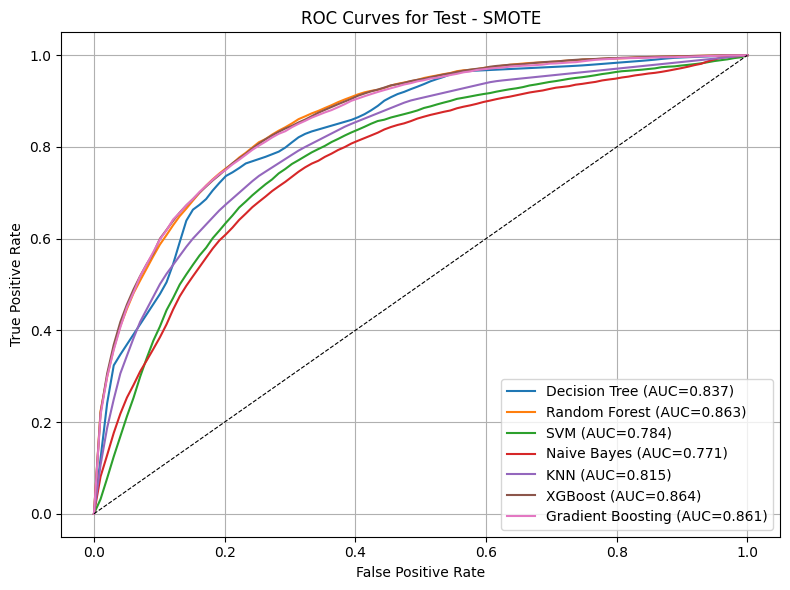

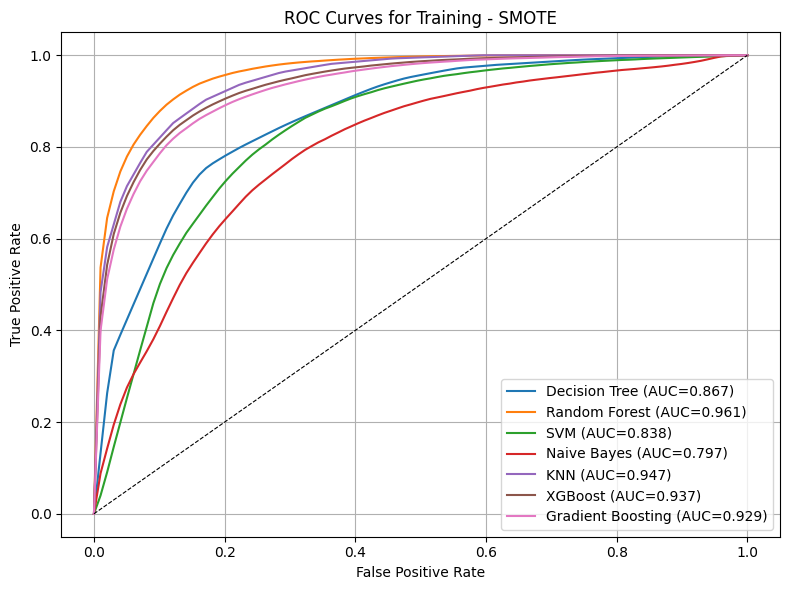


Tabela de Resultados - Teste:
  SMOTE Technique              Model  Accuracy       AUC  Precision  \
0           SMOTE      Decision Tree  0.801938  0.836894   0.402598   
1           SMOTE      Random Forest  0.825662  0.863494   0.441992   
2           SMOTE                SVM  0.740364  0.784347   0.326164   
3           SMOTE        Naive Bayes  0.748578  0.771255   0.326643   
4           SMOTE                KNN  0.784931  0.814583   0.372818   
5           SMOTE            XGBoost  0.824671  0.863940   0.440568   
6           SMOTE  Gradient Boosting  0.821303  0.860831   0.434859   

   Recall rate  F1-score  
0     0.695548  0.509640  
1     0.678978  0.535390  
2     0.708575  0.446699  
3     0.658995  0.436760  
4     0.665315  0.477845  
5     0.686060  0.536539  
6     0.694282  0.534752  

Tabela de Resultados - Treinamento:
  SMOTE Technique              Model  Accuracy       AUC  Precision  \
0           SMOTE      Decision Tree  0.791802  0.866929   0.810423   
1    

In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Dicionários para armazenar as curvas ROC para cada técnica e modelo, separando teste e treinamento
roc_curves_test = {smote_name: {} for smote_name in smote_techniques.keys()}
roc_curves_train = {smote_name: {} for smote_name in smote_techniques.keys()}

# Listas para armazenar os resultados das tabelas para teste e treinamento
results_table_test = []
results_table_train = []

# Iteração entre técnicas de balanceamento e modelos
for smote_name, smote in smote_techniques.items():
    for model_name, model in models.items():
        print(f"\nAplicando {smote_name} com {model_name}")
        mean_fpr = np.linspace(0, 1, 100)

        # Listas para armazenar as curvas e métricas em cada fold (Teste)
        tprs_test = []
        aucs_test = []
        accuracies_test = []
        precisions_test = []
        recalls_test = []
        f1_scores_test = []

        # Listas para armazenar as curvas e métricas em cada fold (Treinamento)
        tprs_train = []
        aucs_train = []
        accuracies_train = []
        precisions_train = []
        recalls_train = []
        f1_scores_train = []

        # Validação cruzada
        for train_index, test_index in kf.split(X, y['Binary Mets']):
            # Separando os dados
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y['Binary Mets'].iloc[train_index], y['Binary Mets'].iloc[test_index]

            # Aplicar SMOTE somente no conjunto de treinamento
            X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

            # Normalizar os dados
            scaler = StandardScaler()
            X_train_res_scaled = scaler.fit_transform(X_train_res)
            X_test_scaled = scaler.transform(X_test)

            # Treinar o modelo com os dados balanceados
            model.fit(X_train_res_scaled, y_train_res)

            # ------------------------------
            # Avaliação no conjunto de Teste
            # ------------------------------
            y_pred_test = model.predict(X_test_scaled)
            y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1]

            # Curva ROC para teste
            fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
            interp_tpr_test = np.interp(mean_fpr, fpr_test, tpr_test)
            interp_tpr_test[0] = 0.0
            tprs_test.append(interp_tpr_test)
            aucs_test.append(auc(fpr_test, tpr_test))

            # Métricas para teste
            accuracies_test.append(accuracy_score(y_test, y_pred_test))
            precisions_test.append(precision_score(y_test, y_pred_test))
            recalls_test.append(recall_score(y_test, y_pred_test))
            f1_scores_test.append(f1_score(y_test, y_pred_test))

            # ------------------------------
            # Avaliação no conjunto de Treinamento
            # ------------------------------
            # Aqui, utiliza-se o conjunto de treinamento já balanceado
            y_pred_train = model.predict(X_train_res_scaled)
            y_pred_proba_train = model.predict_proba(X_train_res_scaled)[:, 1]

            # Curva ROC para treinamento
            fpr_train, tpr_train, _ = roc_curve(y_train_res, y_pred_proba_train)
            interp_tpr_train = np.interp(mean_fpr, fpr_train, tpr_train)
            interp_tpr_train[0] = 0.0
            tprs_train.append(interp_tpr_train)
            aucs_train.append(auc(fpr_train, tpr_train))

            # Métricas para treinamento
            accuracies_train.append(accuracy_score(y_train_res, y_pred_train))
            precisions_train.append(precision_score(y_train_res, y_pred_train))
            recalls_train.append(recall_score(y_train_res, y_pred_train))
            f1_scores_train.append(f1_score(y_train_res, y_pred_train))

        # Cálculo das métricas médias para Teste
        mean_accuracy_test = np.mean(accuracies_test)
        mean_precision_test = np.mean(precisions_test)
        mean_recall_test = np.mean(recalls_test)
        mean_f1_test = np.mean(f1_scores_test)
        mean_auc_test = np.mean(aucs_test)

        # Cálculo das métricas médias para Treinamento
        mean_accuracy_train = np.mean(accuracies_train)
        mean_precision_train = np.mean(precisions_train)
        mean_recall_train = np.mean(recalls_train)
        mean_f1_train = np.mean(f1_scores_train)
        mean_auc_train = np.mean(aucs_train)

        # Armazenar as curvas ROC médias
        roc_curves_test[smote_name][model_name] = (mean_fpr, np.mean(tprs_test, axis=0), mean_auc_test)
        roc_curves_train[smote_name][model_name] = (mean_fpr, np.mean(tprs_train, axis=0), mean_auc_train)

        # Adicionar resultados à tabela de Teste
        results_table_test.append({
            "SMOTE Technique": smote_name,
            "Model": model_name,
            "Accuracy": mean_accuracy_test,
            "AUC": mean_auc_test,
            "Precision": mean_precision_test,
            "Recall rate": mean_recall_test,
            "F1-score": mean_f1_test
        })

        # Adicionar resultados à tabela de Treinamento
        results_table_train.append({
            "SMOTE Technique": smote_name,
            "Model": model_name,
            "Accuracy": mean_accuracy_train,
            "AUC": mean_auc_train,
            "Precision": mean_precision_train,
            "Recall rate": mean_recall_train,
            "F1-score": mean_f1_train
        })

# ------------------------------
# Plotar as curvas ROC para o conjunto de Teste
# ------------------------------
num_techniques = len(roc_curves_test)
fig_test, axes_test = plt.subplots(num_techniques, 1, figsize=(8, 6*num_techniques))
if num_techniques == 1:
    axes_test = [axes_test]
for i, technique in enumerate(roc_curves_test.keys()):
    ax = axes_test[i]
    for model_name, (fpr, tpr, mean_auc) in roc_curves_test[technique].items():
        ax.plot(fpr, tpr, label=f"{model_name} (AUC={mean_auc:.3f})")
    ax.plot([0, 1], [0, 1], 'k--', lw=0.8)
    ax.set_title(f"ROC Curves for Test - {technique}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc='lower right')
    ax.grid()
plt.tight_layout()
plt.show()

# ------------------------------
# Plotar as curvas ROC para o conjunto de Treinamento
# ------------------------------
num_techniques = len(roc_curves_train)
fig_train, axes_train = plt.subplots(num_techniques, 1, figsize=(8, 6*num_techniques))
if num_techniques == 1:
    axes_train = [axes_train]
for i, technique in enumerate(roc_curves_train.keys()):
    ax = axes_train[i]
    for model_name, (fpr, tpr, mean_auc) in roc_curves_train[technique].items():
        ax.plot(fpr, tpr, label=f"{model_name} (AUC={mean_auc:.3f})")
    ax.plot([0, 1], [0, 1], 'k--', lw=0.8)
    ax.set_title(f"ROC Curves for Training - {technique}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc='lower right')
    ax.grid()
plt.tight_layout()
plt.show()

# ------------------------------
# Criar e salvar as tabelas de resultados
# ------------------------------
results_df_test = pd.DataFrame(results_table_test)
results_df_train = pd.DataFrame(results_table_train)

results_df_test.to_csv("comparison_table_test.csv", index=False)
results_df_train.to_csv("comparison_table_train.csv", index=False)

print("\nTabela de Resultados - Teste:")
print(results_df_test)
print("\nTabela de Resultados - Treinamento:")
print(results_df_train)
